# Student Information

Name: 林家榆

Student ID: 109021109

GitHub ID: joylin0123

Kaggle name: joylin0123

Kaggale private scoreboard snapshot:
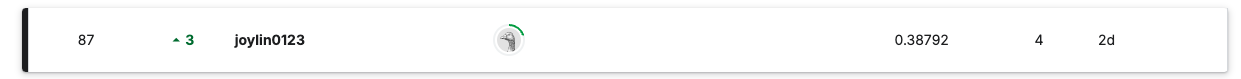

---

## Instructions

1. First: This part is worth 30% of your grade. Do the take home exercises in the DM2024-Lab2-master Repo. You may need to copy some cells from the Lab notebook to this notebook.

2. Second: This part is worth 30% of your grade. Participate in the in-class Kaggle Competition regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking:

    - Bottom 40%: Get 20% of the 30% available for this section.

    - Top 41% - 100%: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)
Submit your last submission BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday). Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the img folder of this repository and rerun the cell Student Information.

3. Third: This part is worth 30% of your grade. A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained.

4. Fourth: This part is worth 10% of your grade. It's hard for us to follow if your code is messy :'(, so please tidy up your notebook.

# Step 1: Import libraries

In [1]:
import json
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Step 2: Data Preprocessing

## Turn CSV files into dataframes

In [2]:
data = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))

print(data[0])
f.close()

{'_score': 391, '_index': 'hashtag_tweets', '_source': {'tweet': {'hashtags': ['Snapchat'], 'tweet_id': '0x376b20', 'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that\'s <LH>'}}, '_crawldate': '2015-05-23 11:42:47', '_type': 'tweets'}


In [3]:
flattened_data = [
    {
        "tweet_id": item["_source"]["tweet"]["tweet_id"],
        "index": item["_index"],
        "score": item["_score"],
        "hashtags": item["_source"]["tweet"]["hashtags"],
        "text": item["_source"]["tweet"]["text"],
        "crawldate": item["_crawldate"],
        "type": item["_type"]
    }
    for item in data
]

# Convert to DataFrame for analysis
tweets_df = pd.DataFrame(flattened_data)
tweets_df.head()

,tweet_id,index,score,hashtags,text,crawldate,type
0,0x376b20,hashtag_tweets,391,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",2015-05-23 11:42:47,tweets
1,0x2d5350,hashtag_tweets,433,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #...",2016-01-28 04:52:09,tweets
2,0x28b412,hashtag_tweets,232,[bibleverse],"Confident of your obedience, I write to you, k...",2017-12-25 04:39:20,tweets
3,0x1cd5b0,hashtag_tweets,376,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,2016-01-24 23:53:05,tweets
4,0x2de201,hashtag_tweets,989,[],"""Trust is not the same as faith. A friend is s...",2016-01-08 17:18:59,tweets


In [4]:
emotion = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv')
emotion.head()

,tweet_id,emotion
0,0x3140b1,sadness
1,0x368b73,disgust
2,0x296183,anticipation
3,0x2bd6e1,joy
4,0x2ee1dd,anticipation


In [5]:
data_identification = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv')
data_identification.head()

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train


Merge all previous loaded data set to `final_df`

In [6]:
merged_df = tweets_df.merge(emotion, on="tweet_id", how="left")

final_df = merged_df.merge(data_identification, on="tweet_id", how="left")

final_df.head()

,tweet_id,index,score,hashtags,text,crawldate,type,emotion,identification
0,0x376b20,hashtag_tweets,391,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",2015-05-23 11:42:47,tweets,anticipation,train
1,0x2d5350,hashtag_tweets,433,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #...",2016-01-28 04:52:09,tweets,sadness,train
2,0x28b412,hashtag_tweets,232,[bibleverse],"Confident of your obedience, I write to you, k...",2017-12-25 04:39:20,tweets,NaN,test
3,0x1cd5b0,hashtag_tweets,376,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,2016-01-24 23:53:05,tweets,fear,train
4,0x2de201,hashtag_tweets,989,[],"""Trust is not the same as faith. A friend is s...",2016-01-08 17:18:59,tweets,NaN,test


Remove features that seems to be unrelated

In [7]:
final_df.drop('type', axis=1, inplace=True)
final_df.drop('index', axis=1, inplace=True)
final_df.drop('score', axis=1, inplace=True)
final_df.drop('hashtags', axis=1, inplace=True)
final_df.drop('crawldate', axis=1, inplace=True)

Check the train/test size

In [8]:
train_df = final_df[final_df['identification'] == 'train']
test_df = final_df[final_df['identification'] == 'test']

print(f"Train set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 1455563
Test set size: 411972


## Undersampling to Deal with Class Imbalance

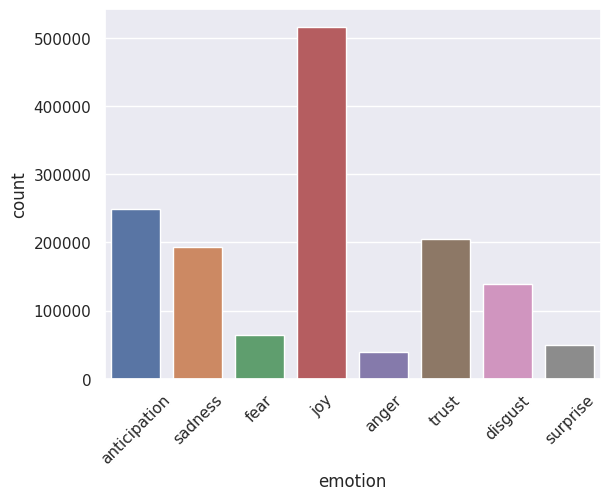

In [9]:
sns.countplot(x='emotion', data=final_df)
plt.xticks(rotation=45)
plt.show()

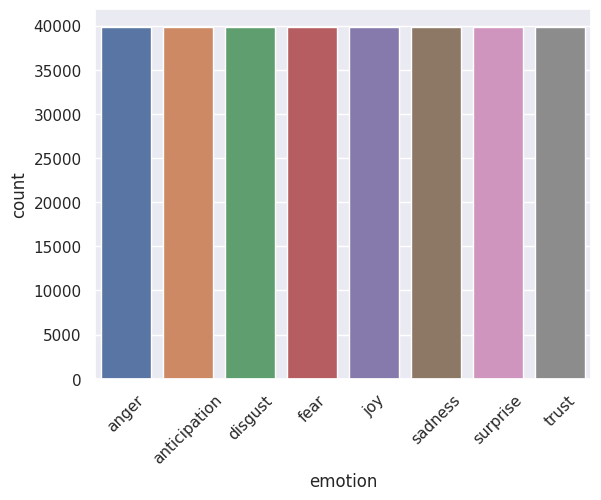

In [10]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(random_state=42)

X = train_df.drop('emotion', axis=1)
y = train_df.emotion

X_over, y_over = undersample.fit_resample(X, y)

sns.countplot(x=y_over, data=train_df)
plt.xticks(rotation=45)
plt.show()

## Plot Word Frequency for Top 30 Words in Train/Test Dataset

Here we can find out the distribution of words in two datesets:
1. There are many stop words in the plots we drawn
2. There are many non-words like '&' in the plots we drawn. 

In [ ]:
from collections import Counter

import matplotlib.pyplot as plt

def plot_top_words_frequency(df, title):
    all_words = ' '.join(df['text']).split()
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(30)
    words, counts = zip(*common_words)
    
    plt.figure(figsize=(10, 8))
    plt.barh(words, counts)
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel('Frequency')
    plt.show()
plot_top_words_frequency(train_df, 'Top 30 Words in Training Dataset')
plot_top_words_frequency(test_df, 'Top 30 Words in Testing Dataset')


## Remove Stop Words and Non-Words

Use `re` to remove URLs, mentions, hashtags, and special characters

In [11]:
import re
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r"[^a-zA-Z\s]", '', text)  # Remove special characters
    return text.lower().strip()

train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

/tmp/ipykernel_24/1744710825.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['text'] = train_df['text'].apply(clean_text)
/tmp/ipykernel_24/1744710825.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['text'] = test_df['text'].apply(clean_text)


In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df['emotion_encoded'] = label_encoder.fit_transform(train_df['emotion'])

/tmp/ipykernel_24/4061730495.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['emotion_encoded'] = label_encoder.fit_transform(train_df['emotion'])


# Step 3: Model Training

## BERT (Don't to try to run this, it is very time consuming)

In [ ]:
train_X = train_df['text']
train_y = train_df['emotion_encoded']
test_X = test_df['text']

1. Load the tokenizer and model
2. Prepare train and test data
3. Compile model
4. Train the model

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=8)

train_encodings = tokenizer(list(train_X), truncation=True, padding=True, max_length=128, return_tensors='tf')
test_encodings = tokenizer(list(test_X), truncation=True, padding=True, max_length=128, return_tensors='tf')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_encodings['input_ids'], train_y, batch_size=32, epochs=1)


1. Use tokenizer to turn test data into encodings.
2. Use the trained model to predict.
3. Turn the prediction into emotion labels.
4. Transform and save the predicated labels.

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
import numpy as np

test_encodings = tokenizer(list(test_X), truncation=True, padding=True, max_length=128, return_tensors='tf')

test_predictions = model.predict(test_encodings['input_ids'])[0]
predicted_labels = np.argmax(test_predictions, axis=1)

test_df['predicted_emotion'] = label_encoder.inverse_transform(predicted_labels)

submission = pd.DataFrame({
    'id': test_df['tweet_id'],
    'emotion': test_df['predicted_emotion']
})
submission.to_csv('/kaggle/working/submission_bert.csv', index=False)


## Logistic Regression

In [71]:
train_X = train_df['text']
train_y = train_df['emotion_encoded']

test_X = test_df['text']

The purpose of this process is to convert raw text data into numerical feature matrices that can be used by machine learning models. TF-IDF emphasizes words that are both frequent in a document and unique to it, which helps capture the semantic relevance of words in text data.

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(train_X)
X_test_vec = tfidf.transform(test_X)

- Preprocessing:
  Standardizes the TF-IDF features to ensure efficient and stable training of the logistic regression model.
- Training:
  Trains a logistic regression model on the scaled TF-IDF features to predict the class labels for a text classification task (e.g., spam detection, sentiment analysis).
- Prediction:
  Uses the trained model to predict the labels for the test data.

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)  # TF-IDF vectors are sparse, so use `with_mean=False`
X_train_scaled = scaler.fit_transform(X_train_vec)
X_test_scaled = scaler.transform(X_test_vec)

model = LogisticRegression(max_iter=1000, random_state=42)

model.fit(X_train_scaled, train_y)

test_predictions = model.predict(X_test_scaled)


- Decoding Predictions:

  Converts numerical predictions (test_predictions) back to their original categorical labels (e.g., "happy," "sad") using label_encoder.inverse_transform.
- Preparing Submission:

  Constructs a DataFrame with the id of each tweet and its predicted emotion.
- Saving as CSV:

  Exports the DataFrame to a CSV file.

In [74]:
test_df['predicted_emotion'] = label_encoder.inverse_transform(test_predictions)

submission = pd.DataFrame({
    'id': test_df['tweet_id'],
    'emotion': test_df['predicted_emotion']
})
submission.to_csv('/kaggle/working/submission2.csv', index=False)

/tmp/ipykernel_24/3646833079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_emotion'] = label_encoder.inverse_transform(test_predictions)


## XGBC Model

In [ ]:
train_X = train_df['text']
train_y = train_df['emotion_encoded']

test_X = test_df['text']

This part is the same as the Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(train_X)
X_test_vec = tfidf.transform(test_X)

Here we use XGBClassifer to train and fit the model.

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(n_estimators=100, max_depth=8, random_state=42, objective='multi:softmax', num_class=8)
xgb_model.fit(X_train_vec, train_y)

test_predictions = xgb_model.predict(X_test_vec)

This part is to inverse the labels and save the result.

In [ ]:
test_df['predicted_emotion'] = label_encoder.inverse_transform(test_predictions)

submission = pd.DataFrame({
    'id': test_df['tweet_id'],
    'emotion': test_df['predicted_emotion']
})
submission.to_csv('/kaggle/working/submission_xgbc.csv', index=False)

# Final Comments

#### Data Preprocessing

I tried to use `nltk` to preprocess the text data, so that i can remove the stopwords and punktuations before model training.
It turned out that the result did not improve, so I removed this method before the competition.

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download required resources
nltk.download('stopwords')
nltk.download('punkt')

def remove_stopwords(df):
    stop_words = set(stopwords.words('english'))
    df['text'] = df['text'].apply(
        lambda text: ' '.join([word for word in word_tokenize(text) if word.lower() not in stop_words])
    )
remove_stopwords(train_df)
remove_stopwords(test_df)

#### Undersampling
From the result, the undersampling for preprocessing did not work as much as i predicted, I believe the reason might be that the undersampling technique removed too many important examples from the majority class, which led to a loss of valuable information. This could have affected the model's ability to generalize effectively, especially if the remaining data did not adequately represent the majority class's distribution.

#### Model Comparison
1. BERT

    - Pros: A pretrained model with contextual understanding of inputs, capturing complex patterns in text.
    - Cons: Too time-consuming and computationally intensive; unable to finish training before the deadline.
2. Logistic Regression

    - Pros: Achieved the best accuracy among the models tested; simple to implement and fast to train.
    - Cons: Limited capacity to capture non-linear relationships in data, making it less effective for complex patterns.
3. XGBC (Extreme Gradient Boosting Classifier)

    - Pros: Handles imbalanced data well and provides robust performance with efficient computation.
    - Cons: Requires careful hyperparameter tuning, which can be time-consuming, and its performance is slightly lower than Logistic Regression in this specific task.

#### Where can I Improve
1. Hyperparameter Tuning

    Experiment with different settings for models like Logistic Regression and XGBC to optimize their performance.
2. Try Clustering

    Use clustering techniques (e.g., K-Means, DBSCAN) to group similar data points and potentially enhance feature engineering or preprocessing.
3. Data Augmentation

    Increase dataset size and diversity by creating synthetic samples or augmenting existing data, especially for the minority class.
4. Explore Other Models

    Test advanced models like Random Forest or Support Vector Machines to compare performance.
5. Evaluate Different Metrics

    Focus on precision, recall, and F1-score to better assess model performance, particularly in imbalanced datasets.